# Visualization for Delegation Based Lock

In [121]:
@time using DataFrames, CSV, DataFramesMeta

bench_10ns = @time CSV.read("output/output_nc_10ns.csv", DataFrame)
bench_0ns = @time CSV.read("output/output.csv", DataFrame)

@subset!(bench_10ns, :Locktype .!= "Flat Combining Fair With Combiner Slice");
@subset!(bench_0ns, :Locktype .!= "Flat Combining Fair With Combiner Slice");

  0.003682 seconds (1.35 k allocations: 90.797 KiB)
  0.013787 seconds (2.71 k allocations: 474.203 KiB)


  0.023179 seconds (2.71 k allocations: 393.672 KiB)


In [122]:
function save_display(fig, filename)
    save("graphs/$filename.svg", fig)
    display(fig);
end

save_display (generic function with 1 method)

In [123]:
using AlgebraOfGraphics, CairoMakie
using AlgebraOfGraphics: density
using DataFramesMeta

CairoMakie.activate!(type="svg")

function loop_per_thread_hist(bench_data, data_name, thread_num = 32)
        loop_comparison = ((@chain bench_data begin
                @subset(:ThreadNum .== thread_num)
        end) |> data) * mapping(:LoopCount, layout = :Locktype, color = :WaiterType => nonnumeric) * (visual(Hist, bins=10, alpha=0.5))
            
        # savefig(loop_comparison, "graphs/loop_comparison.svg")
        fig = draw(loop_comparison, figure=(resolution=(1000,600),))
        
        save_display(fig, "loop_comparison_per_thread_histogram_$(data_name).svg")
end

loop_per_thread_hist (generic function with 4 methods)

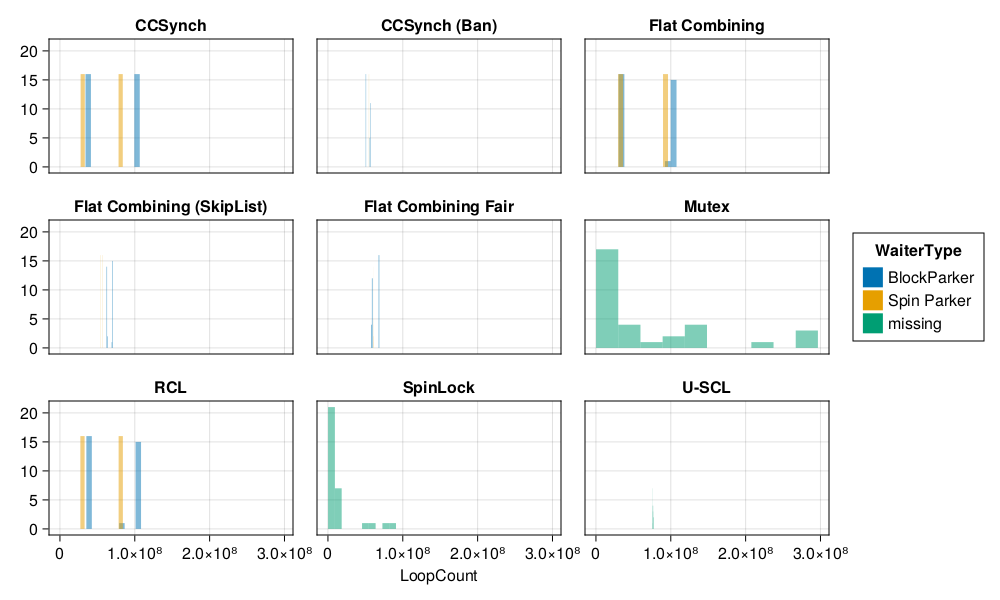

CairoMakie.Screen{IMAGE}


In [124]:
loop_per_thread_hist(bench_0ns, "0ns")

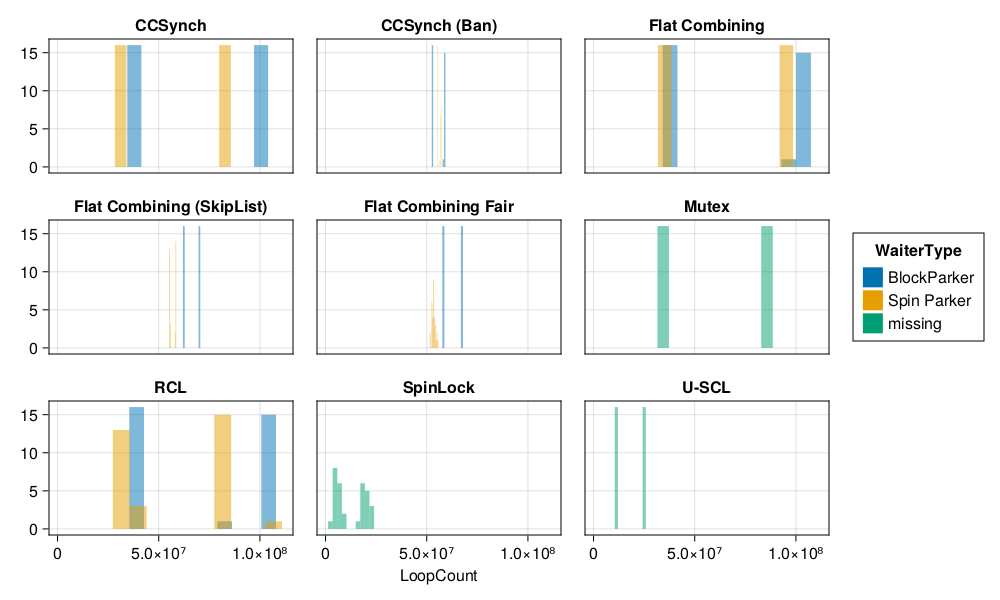

CairoMakie.Screen{IMAGE}


In [125]:
loop_per_thread_hist(bench_10ns, "10ns")

In [126]:
using AlgebraOfGraphics, CairoMakie
using AlgebraOfGraphics: density
using Tidier

CairoMakie.activate!(type = "svg")

function loop_per_thread(bench, data_name, thread_num = 32)
        loop_comparison = ((@chain bench begin
                @subset(:ThreadNum .== thread_num)
        end) |> data) * mapping(:Id, :LoopCount, layout = :Locktype, color = :WaiterType) * (visual(Scatter, alpha = 0.5) + visual(Lines))
            
        # savefig(loop_comparison, "graphs/loop_comparison.svg")
        fig = draw(loop_comparison, figure = (resolution = (1100,600),))
        
        save_display(fig, "loop_comparison_per_thread_$data_name")
end



loop_per_thread (generic function with 2 methods)

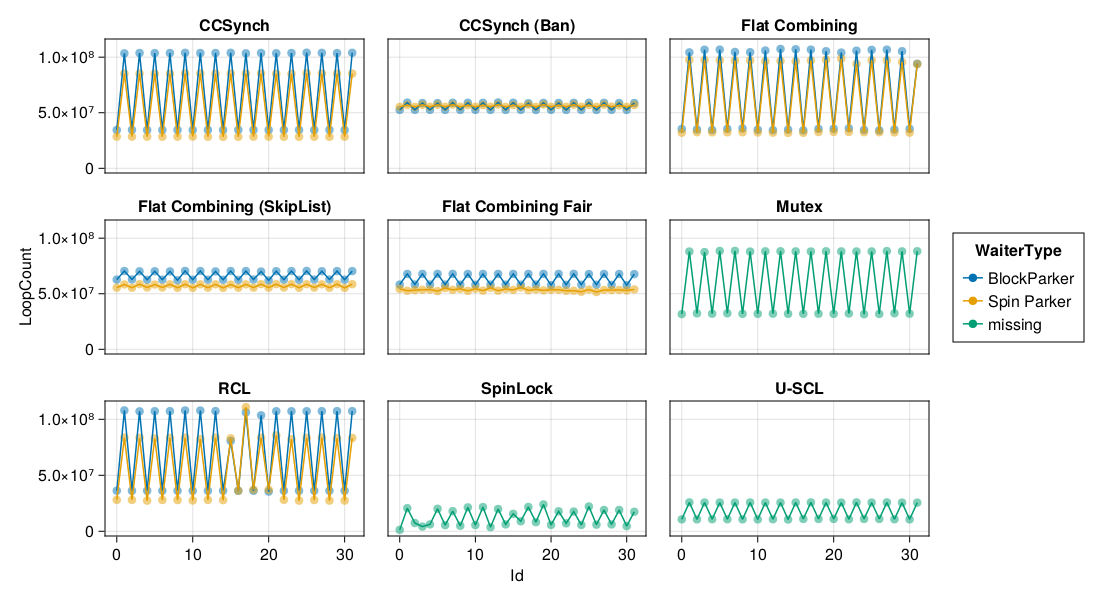

CairoMakie.Screen{IMAGE}


In [127]:
loop_per_thread(bench_10ns, "10ns")

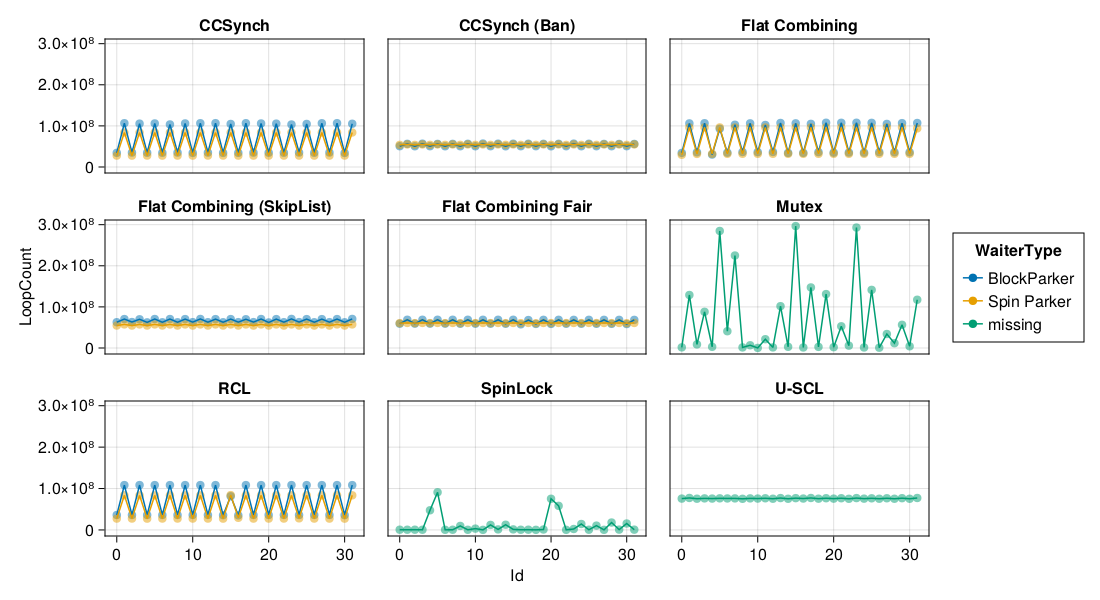

CairoMakie.Screen{IMAGE}


In [128]:
loop_per_thread(bench_0ns, "0ns")

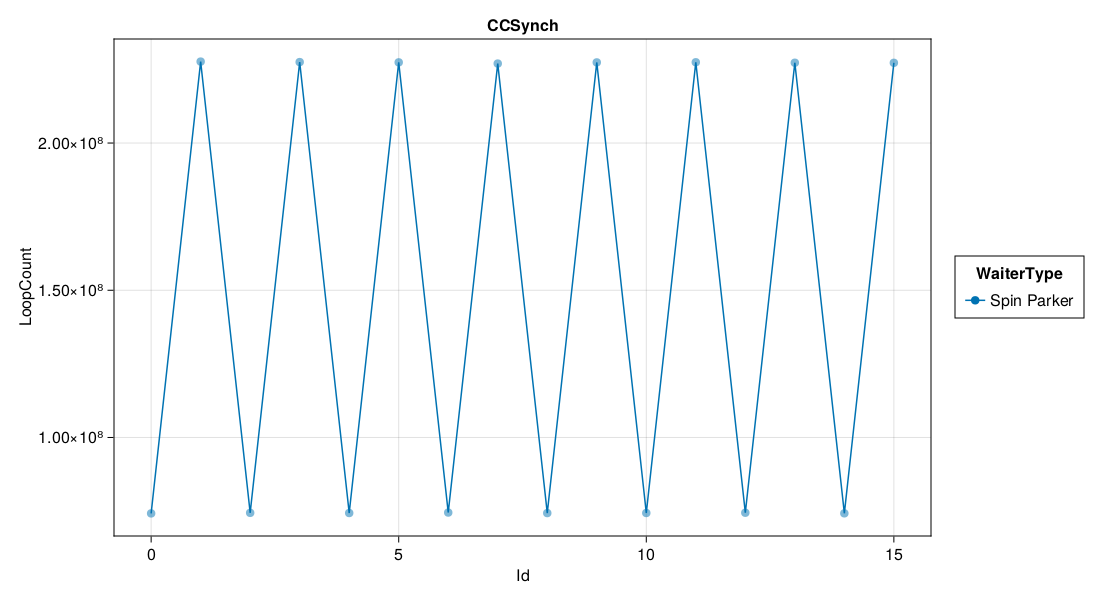

CairoMakie.Screen{IMAGE}


In [129]:
using AlgebraOfGraphics, CairoMakie
using AlgebraOfGraphics: density
using Tidier

CairoMakie.activate!(type="svg")

loop_per_thread(begin
        @chain bench_0ns begin
            @subset((:Locktype .== "CCSynch") .&& (:WaiterType .== "Spin Parker"))
        end
    end, "ccsynch (0ns)", 16)

In [130]:
using Tidier
using AlgebraOfGraphics, CairoMakie

function loop_together(bench, data_name)
    bench2 = @chain bench begin
        @group_by(Locktype, WaiterType, ThreadNum)
        @summarise(LoopCount = sum(LoopCount))
        @ungroup
    end
    
    plt = data(bench2) * mapping(:ThreadNum, :LoopCount, marker = :Locktype, color = :Locktype, layout = :WaiterType) * (visual(Lines, alpha=0.5) + visual(Scatter, alpha=0.5))
    
    fig = draw(plt, figure = (resolution=(1200,600),))
    
    save_display(fig, "loop_comparison_together_$data_name")
end

loop_together (generic function with 1 method)

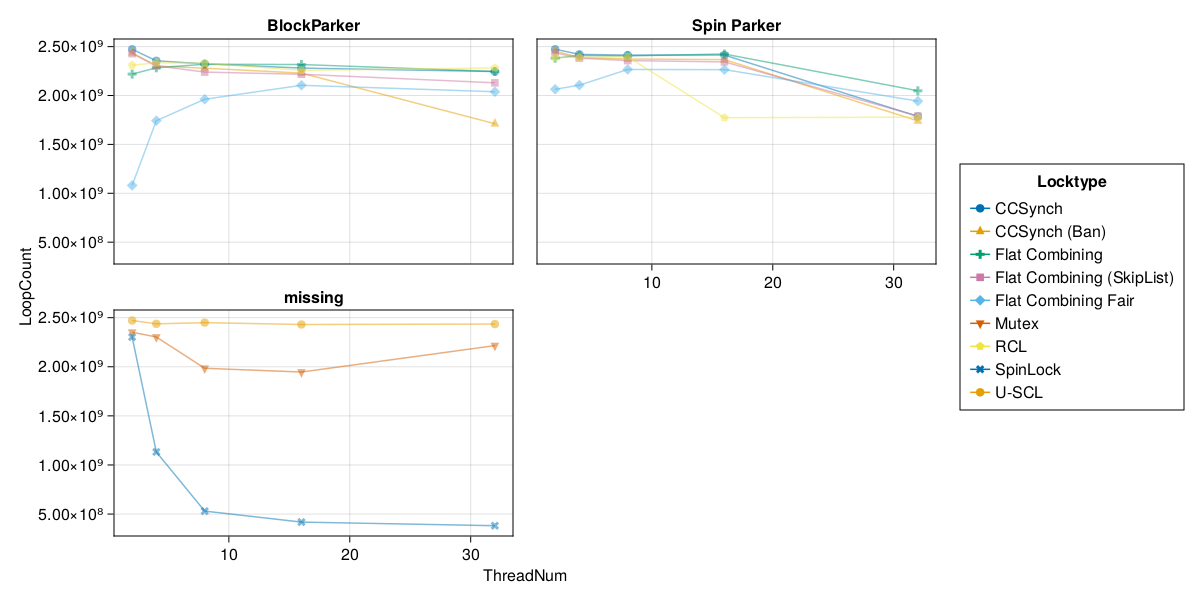

CairoMakie.Screen{IMAGE}


In [131]:
loop_together(bench_0ns, "0ns")

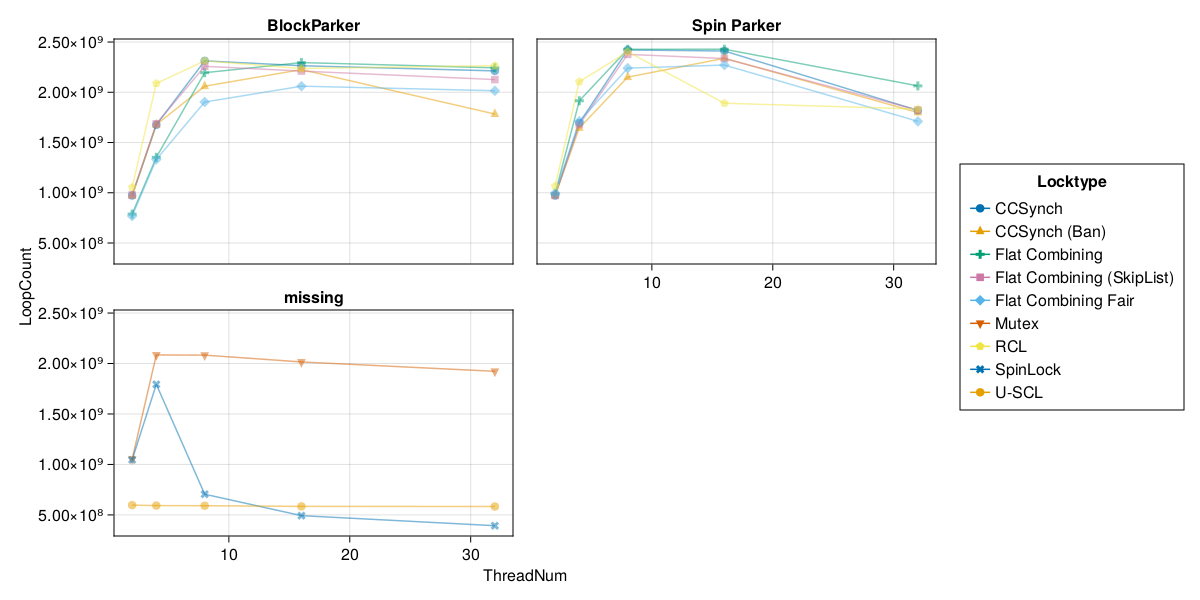

CairoMakie.Screen{IMAGE}


In [132]:
loop_together(bench_10ns, "10ns")

In [133]:
using Tidier
using AlgebraOfGraphics, CairoMakie

function loop_split(bench, data_name)
    bench2 = @chain bench begin
        @group_by(Locktype, WaiterType, ThreadNum)
        @summarise(LoopCount = sum(LoopCount))
        @ungroup
    end
    
    plt = data(bench2) * mapping(:ThreadNum, :LoopCount, layout = :Locktype, color = :WaiterType) * (visual(Lines) + visual(Scatter))
    
    fig = draw(plt, figure = (resolution=(1200,600),))
    
    save_display(fig, "loop_comparison_split")
end

loop_split (generic function with 1 method)

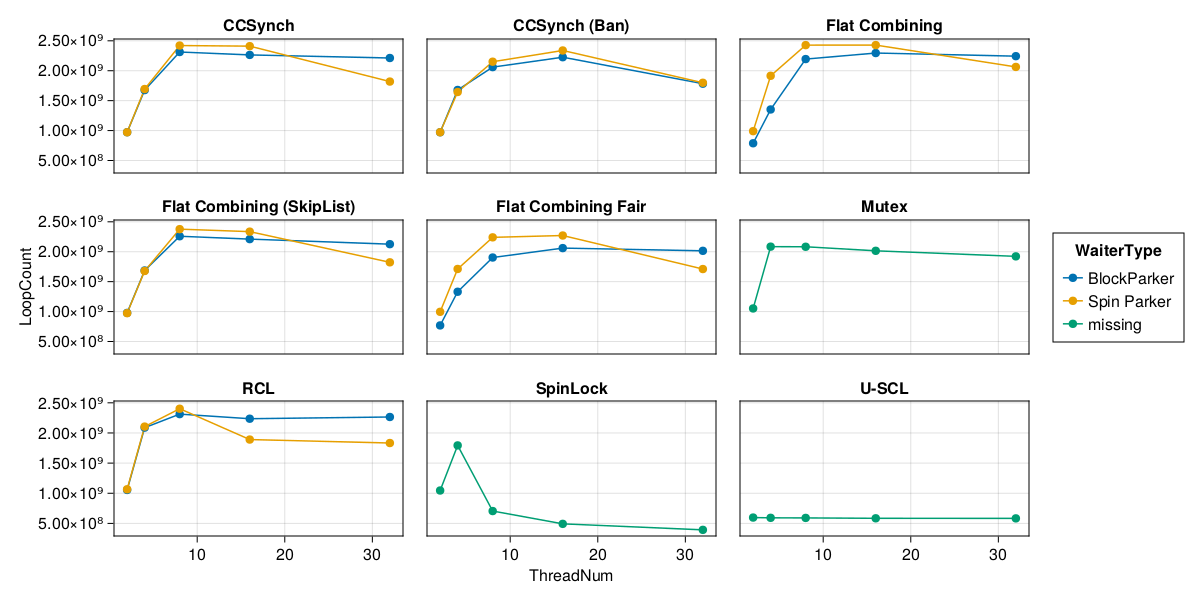

CairoMakie.Screen{IMAGE}


In [134]:
loop_split(bench_10ns, "10ns")

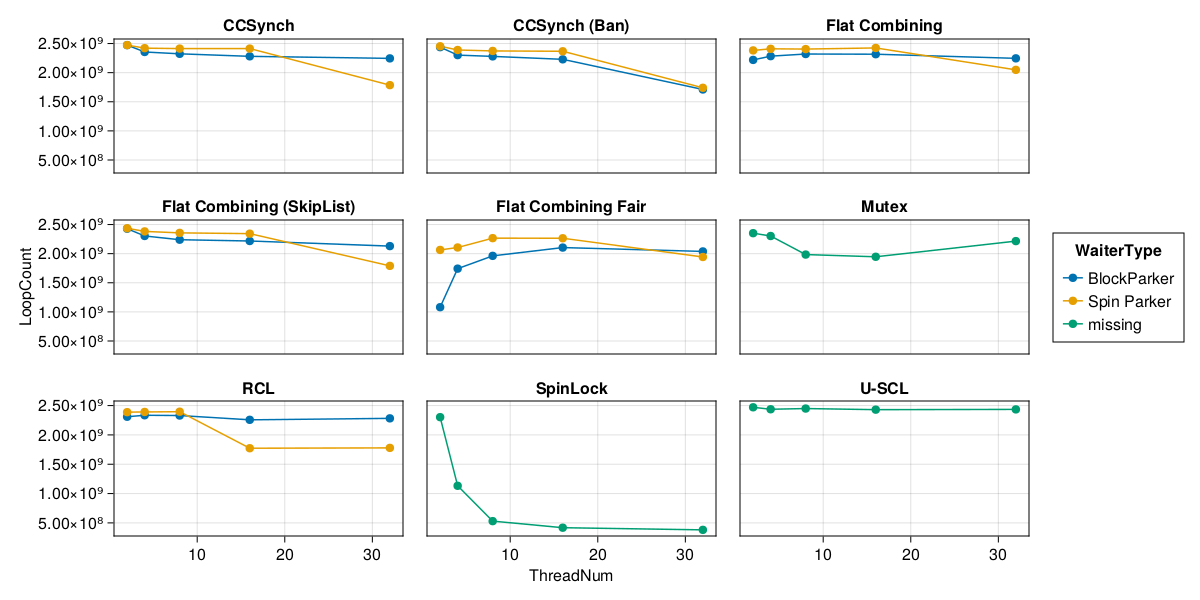

CairoMakie.Screen{IMAGE}


In [135]:
loop_split(bench_0ns, "0ns")

In [136]:
using DataFrames, Tidier, AlgebraOfGraphics, CairoMakie

function combine_box(bench, data_name)
    bench_32thread = @chain dropmissing(bench) begin
        Tidier.@filter(ThreadNum == 32)
    end

    plt = data(bench_32thread) * mapping(:Locktype, :CombineTime, layout=:WaiterType) * (visual(BoxPlot) + (visual(Scatter, color="lightblue", strokewidth=1)))


    fig = draw(plt, axis=(xticklabelrotation=pi / 5,), figure=(resolution=(1000, 600),))

    save_display(fig, "combining_time_box_plot")
end

combine_box (generic function with 1 method)

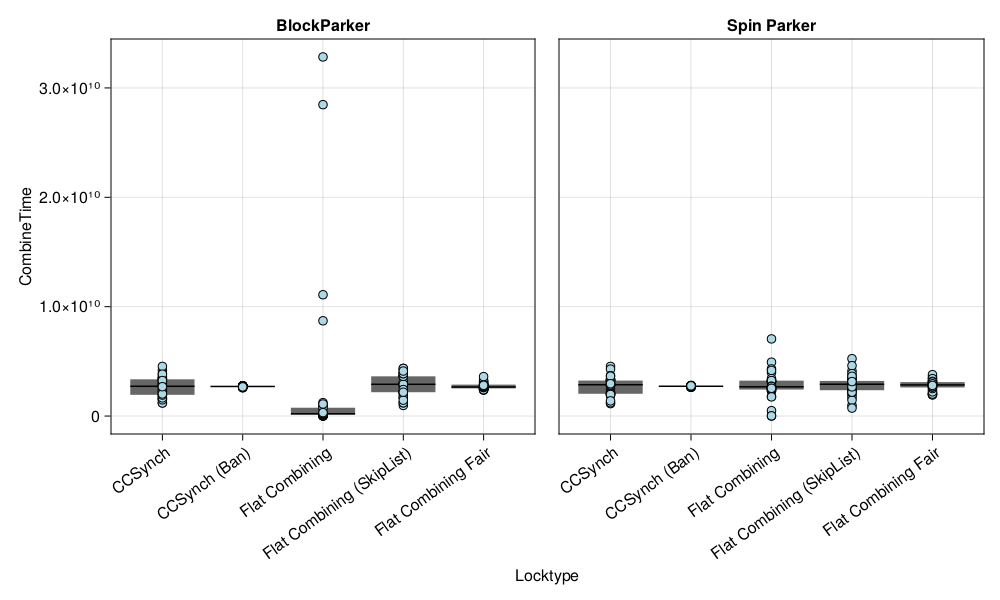

CairoMakie.Screen{IMAGE}


In [137]:
combine_box(bench_10ns, "10ns")

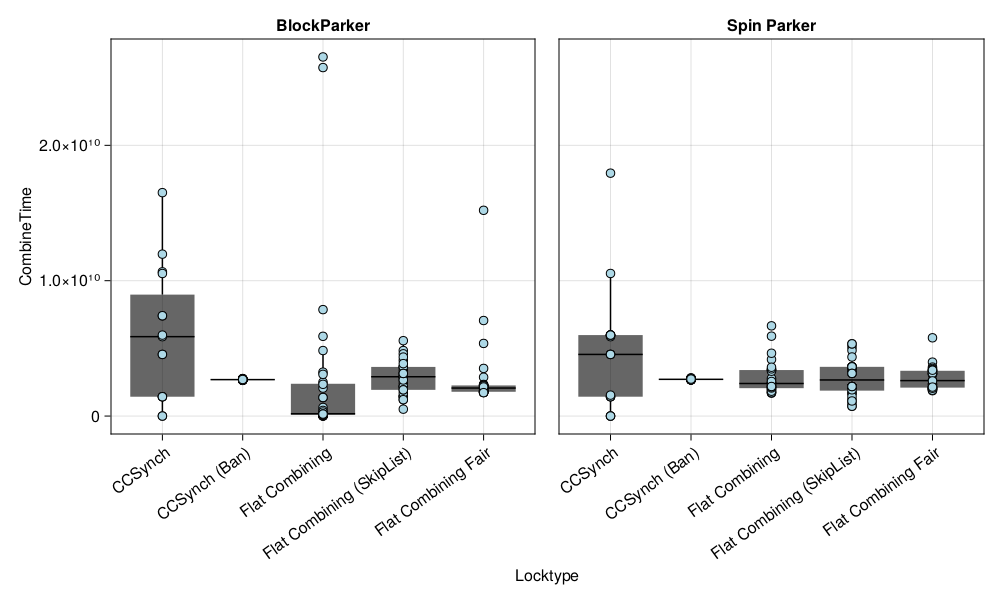

CairoMakie.Screen{IMAGE}


In [138]:
combine_box(bench_0ns, "0ns")

Dict{String, Any} with 9 entries:
  "cpu_num"        => 16
  "thread_num"     => 16
  "waiter_type"    => ""
  "hold_time"      => Dict{String, Any}("secs"=>0, "nanos"=>6211097)
  "combine_time"   => nothing
  "id"             => 0
  "response_times" => Any[52231041, 10583, 11578732, 10609, 38350940, 10665, 11…
  "locktype"       => "Mutex"
  "cpu_id"         => 0

In [11]:
using JSON, DataFrames

files = readdir("output/response_times")

response_times_data = DataFrame(locktype=String[], waiter_type=Union{String, Missing}[], cpu_id=String[], response_time=Int[])

for file in files

    # name = splitext(file)[1]
    
    # infos = split(name, "-")
    # locktype = infos[1]
    # waiter_type = infos[2] == "" ? nothing : infos[2]
    # num_cpu = infos[3]
    # num_thread = infos[4]

    datas = JSON.parsefile("output/response_times/$file")

    for data in datas 
        for time in data["response_times"]
            push!(response_times_data, (data["locktype"], data["waiter_type"] == "" ? missing : data["waiter_type"], string(data["id"]), time))
        end
    end
end

response_times_data

# records = DataFrame(locktype=String[], waiter_type=String[], id=String[], response_time=Int[])


# for record in response_times
#     for time in record["response_times"]
#         push!(records, (record["locktype"], record["waiter_type"], string(record["id"]), time))
#     end
# end

# records

132220×4 DataFrame
    Row │ locktype  waiter_type  cpu_id  response_time 
        │ String    String?      String  Int64         
────────┼──────────────────────────────────────────────
      1 │ Mutex     missing      0               20394
      2 │ Mutex     missing      0               18693
      3 │ Mutex     missing      0               17668
      4 │ Mutex     missing      0            95394500
      5 │ Mutex     missing      0               10554
      6 │ Mutex     missing      0             1956506
      7 │ Mutex     missing      0               10652
      8 │ Mutex     missing      0               85388
   ⋮    │    ⋮           ⋮         ⋮           ⋮
 132214 │ Mutex     missing      15              38071
 132215 │ Mutex     missing      15              39326
 132216 │ Mutex     missing      15              38000
 132217 │ Mutex     missing      15              37760
 132218 │ Mutex     missing      15              30354
 132219 │ Mutex     missing      15              30281
 132220 │ Mutex     missing      15           10132879
                                    132205 rows omitted

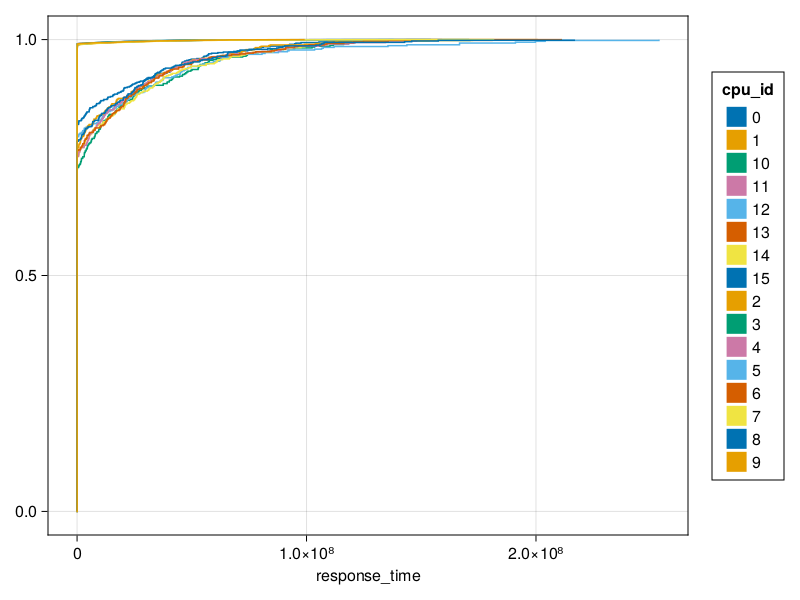

In [15]:
using Tidier, AlgebraOfGraphics, CairoMakie

plt = data(response_times_data) * mapping(:response_time, color = :cpu_id, layout = :locktype) * visual(ECDFPlot)

draw(plt)